**Import**

In [1]:
import re

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from gensim.models import Word2Vec
from germansentiment import SentimentModel
from nltk import FreqDist
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize, word_tokenize
from PIL import Image
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from transformers import AutoModel, AutoTokenizer
from wordcloud import ImageColorGenerator, WordCloud

%load_ext Cython

# config plot
plt.rcParams["figure.figsize"] = (12, 7)
sns.set(style="ticks", context="talk")
plt.style.use("seaborn-dark")


df_init = pd.read_csv("datas/data Kiel's restaurants 17-11-2021 .csv")

**Data cleaning**

In [42]:
df_init["Comment_concatenate"] = df_init["Comment"] + df_init["Names_pictures"]
df_init["Comment_concatenate"] = df_init["Comment_concatenate"].replace(
    r"[?${}.!/-]", r" ", regex=True
)
df_init["label"] = np.where(df_init["Rating"] > 2.5, 1, 0)

**Some stats**

Text(0.5, 1.0, 'Distribution of Customer Rating')

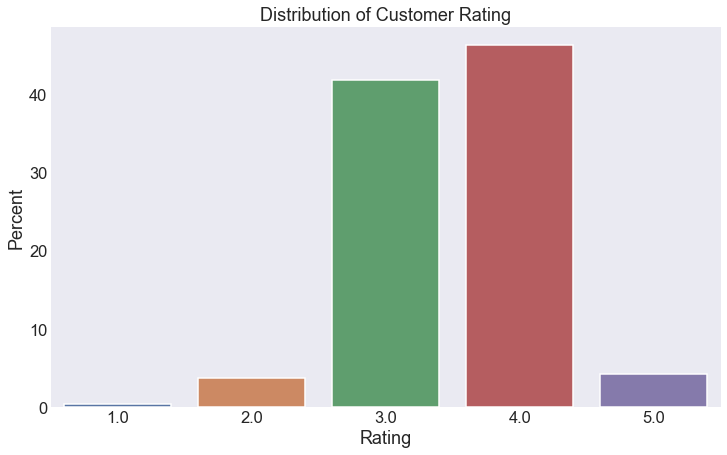

In [43]:
df = df_init.copy()

ax = sns.barplot(
    data=df, x="Rating", y="Rating", estimator=lambda x: len(x) / len(df) * 100
)

ax.set(ylabel="Percent")
plt.title("Distribution of Customer Rating")

**Wordcloud**

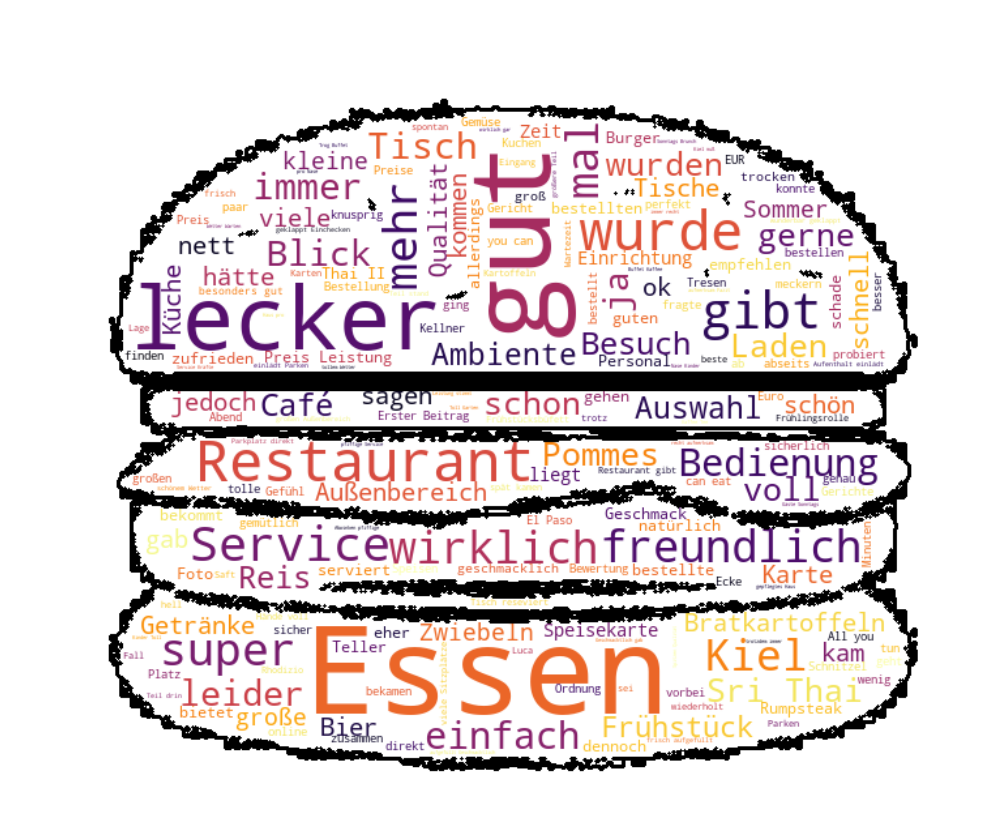

In [44]:
my_stop_words = set(stopwords.words("german"))

plt.rcParams["figure.figsize"] = (30, 15)
df["Comment_concatenate"] = df["Comment"] + df["Names_pictures"]
df = df[df["Comment_concatenate"].notna()]

full_text = " ".join(df["Comment_concatenate"].astype("str"))
burger = np.array(Image.open("burger.jpg"))

cloud_no_stopword = WordCloud(
    background_color="white",
    colormap="inferno",
    mask=burger,
    contour_width=3,
    contour_color="black",
    stopwords=my_stop_words,
).generate(full_text)


plt.imshow(cloud_no_stopword, interpolation="bilinear")
plt.axis("off")
plt.show()

**Top Words**

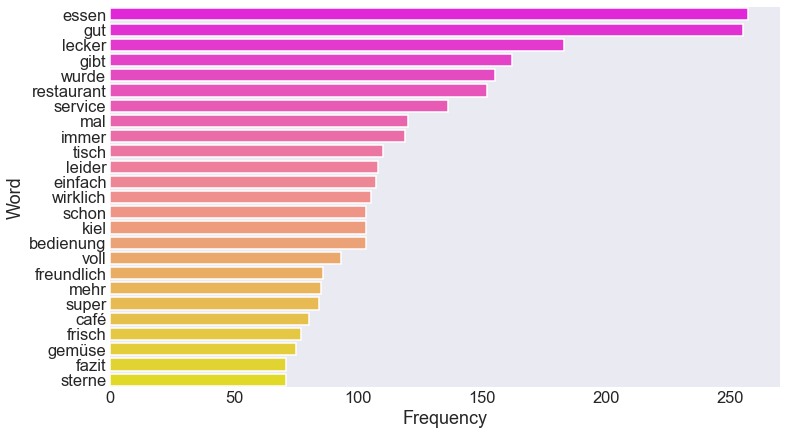

In [45]:
plt.rcParams["figure.figsize"] = (12, 7)
lower_full_text = full_text.lower()
word_tokens = word_tokenize(lower_full_text)
tokens = list()
for word in word_tokens:
    if word.isalpha() and word not in my_stop_words:
        tokens.append(word)

token_dist = FreqDist(tokens)
dist = pd.DataFrame(token_dist.most_common(25), columns=["Word", "Frequency"])

sns.barplot(x="Frequency", y="Word", data=dist, palette="spring")
plt.show()

**Top Groupwords**

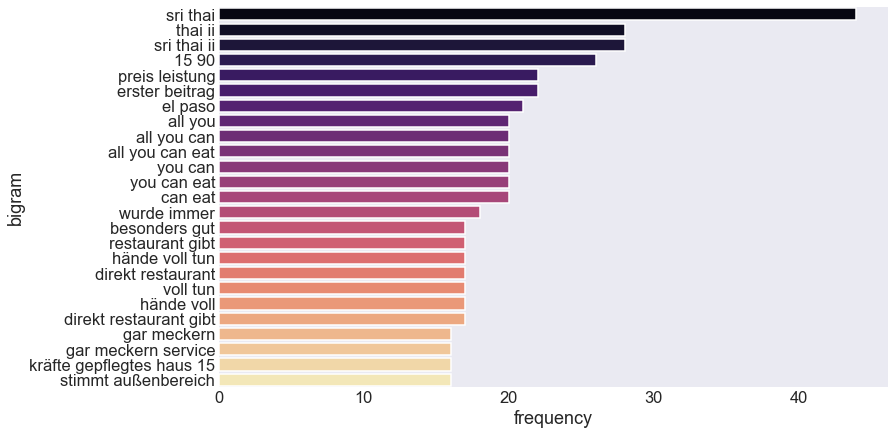

In [46]:
vect = CountVectorizer(stop_words=my_stop_words, ngram_range=(2, 4))
bigrams = vect.fit_transform(df["Comment_concatenate"])
bigram_df = pd.DataFrame(bigrams.toarray(), columns=vect.get_feature_names())
bigram_frequency = pd.DataFrame(bigram_df.sum(axis=0)).reset_index()
bigram_frequency.columns = ["bigram", "frequency"]
bigram_frequency = bigram_frequency.sort_values(by="frequency", ascending=False).head(
    25
)

sns.barplot(x="frequency", y="bigram", data=bigram_frequency, palette="magma")
plt.show()

**Word2Vec**

In [50]:
df_good = df[df["label"] == 1]
good_reviews = " ".join(df_good.Comment_concatenate.astype(str))

# split the long string into sentences
df["sentences"] = df["Comment_concatenate"].apply(
    lambda a: sent_tokenize(a, language="german")
)

sentences_good = sent_tokenize(good_reviews, language="german")
good_token_clean = list()

# get tokens for each sentence
for sentence in sentences_good:
    word = re.findall(r"[a-zA-Z0-9äöüÄÖÜß]+", sentence)
    good_token_clean.append([i.lower() for i in word if i.lower() not in my_stop_words])

model_ted = Word2Vec(
    sentences=good_token_clean, window=10, min_count=1, workers=4, sg=0
)

 
model_ted.predict_output_word(["pommes"], topn=10)

[('feiern', 0.0002451618),
 ('behaupte', 0.00024514226),
 ('dekoriert', 0.00024510178),
 ('komplette', 0.00024507352),
 ('porzelantellern', 0.0002450575),
 ('schwer', 0.00024505428),
 ('erwachsene', 0.00024503554),
 ('bemängeln', 0.00024503327),
 ('trinkgeld', 0.00024496287),
 ('optik', 0.0002449617)]

**Sentiment**

In [51]:
%%cython
import numpy as np
from germansentiment import SentimentModel

sid = SentimentModel()


def sentiment_score(text):
    case = {"negative": -1, "positive": 0.8, "neutral": 0}
    sentiments = list(map(case.get, sid.predict_sentiment(text)))
    return np.mean(sentiments)

In [52]:
df["sentiment_score"] = df["sentences"].apply(sentiment_score)

RuntimeError: [enforce fail at ..\c10\core\CPUAllocator.cpp:76] data. DefaultCPUAllocator: not enough memory: you tried to allocate 5246976 bytes.

In [ ]:
sns.barplot(y="sentiment_score", x="Rating", data=df, palette="magma")
plt.show()

In [ ]:
Classement = df.groupby(["Name"], as_index=False).agg(
    {"sentiment_score": "mean", "Rating": "mean", "Comment": "count"}
)
plt.style.use("seaborn-dark")
plt.rcParams["figure.figsize"] = (25, 15)

size = set(df["Comment"].to_list())
sns.barplot(
    y="sentiment_score",
    x="Name",
    data=Classement.sort_values(["sentiment_score"]),
    palette="magma",
)
plt.xticks(rotation=80)
ax2 = plt.twinx()
sns.scatterplot(
    y="Rating",
    x="Name",
    data=Classement.sort_values(["Rating"]),
    ax=ax2,
    size="Comment",
    hue="Comment",
    linewidth=3,
    sizes=(100, 600),
)

plt.plot(
    Classement.sort_values(["Rating"])["Name"],
    Classement.sort_values(["Rating"])["Rating"],
    color="xkcd:magenta",
    linewidth=4,
)
plt.show()

In [ ]:
Classement.sort_values(["Comment"])